In [1]:
!pip install transformers -q
!pip install sentencepiece -q

     |████████████████████████████████| 3.3 MB 14.6 MB/s 
     |████████████████████████████████| 61 kB 340 kB/s 
     |████████████████████████████████| 895 kB 64.9 MB/s 
     |████████████████████████████████| 3.3 MB 69.8 MB/s 
     |████████████████████████████████| 596 kB 79.2 MB/s 
     |████████████████████████████████| 1.2 MB 15.3 MB/s 


In [3]:
# # Mount Google drive to upload datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# The path to the data on my drive
D = '/content/drive/My Drive/W266_Project_Data/pmi_data'

In [5]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import copy
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch import optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
# Load the paraphrase training, dev, and test sets created with punjabi
paraphrase_train = pd.read_csv(D+"/xml/amrita-paraphrase-exact/paraphrase_train_w_punjabi.csv")
paraphrase_train.drop(columns={"Unnamed: 0"}, inplace=True)

paraphrase_dev = pd.read_csv(D+"/xml/dedup_para_dev.csv")
paraphrase_dev.drop(columns={"Unnamed: 0"}, inplace=True)

paraphrase_test = pd.read_csv(D+"/xml/dedup_para_test.csv")
paraphrase_test.drop(columns={"Unnamed: 0"}, inplace=True)

In [10]:
paraphrase_train.head()

,sentence_1,sentence_2,label,language_task
0,मेहरुन्निसा की शादी पाकिस्तान के जाने माने कार...,पीएम मोदी के तोहफे को अपने सिर बांध नवाज शरीफ ...,0,translate English to Hindi
1,"ஜம்மு - காஷ்மீரில், 13 இந்திய நிலைகளை நோக்கி, ...","இந்திய படையினரிடம், சமாதானத்திற்கான வெள்ளைக் க...",0,translate English to Tamil
2,രാഹുൽ ഗാന്ധിയുടെ നിർദേശമനുസരിച്ചായിരുന്നു മത്സ...,സ്ഥാനാർഥിയാക്കരുതെന്ന് അഭ്യർഥിച്ചു കത്തുനൽകിയ ...,0,translate English to Malayalam
3,4 மணிநேரத்தில் 40 சதவீதம் வாக்குகள் மேற்கு வங்...,மேற்கு வங்காளத்தில் ஐந்தாம்கட்ட சட்டசபை தேர்தல...,1,translate English to Tamil
4,உத்திரமேரூர் அருகே மோட்டார் சைக்கிள் விபத்தில்...,இந்த விபத்து குறித்து உத்திரமேரூர் போலீசார் வழ...,0,translate English to Tamil


In [11]:
# Set up the device to run on GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [12]:
# Create an instance of the tokenizer and model using Indic Bert
tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert', keep_accents=True)
model = AutoModel.from_pretrained('ai4bharat/indic-bert')

Downloading:   0%|          | 0.00/507 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.38M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129M [00:00<?, ?B/s]

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['sop_classifier.classifier.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.bias', 'predictions.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'sop_classifier.classifier.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def sentence_embeddings(device, tokenizer, model, sentences):
  """Create contextualized sentence embeddings
  
  Parameters:
  tokenizer: transformers tokenizer for creating word tokens
  model:
  sentences: sentences to generate sentence embeddings for
  """

  # Tokenize sentences and return PyTorch tensors
  encoded_input = tokenizer(sentences, padding=True, truncation=True, 
                            max_length=128, return_tensors='pt')
  encoded_input = encoded_input.to(device)
  
  # Pass the tokenized input to the model 
  with torch.no_grad():
    model.to(device)
    model_output = model(**encoded_input) 
  
  # Perform mean pooling to get total sentence embeddings
  sentence_embeddings = mean_pooling(model_output, 
                                     encoded_input['attention_mask'])
  
  return sentence_embeddings

In [14]:
# An object to split and parse the training and test data fields
class SiameseNetworkDataset(Dataset): 
  def __init__(self,training_df, device, tokenizer, model):
    self.training_df=training_df
    self.sent1 = self.training_df['sentence_1'].tolist()
    self.sent2 = self.training_df['sentence_2'].tolist()
    self.language_task = self.training_df['language_task'].tolist()
    self.label = self.training_df['label'].tolist()
    self.device = device
    self.tokenizer = tokenizer
    self.model = model

  def __getitem__(self, index):
    sent1 = self.sent1[index]
    sent2 = self.sent2[index]
    task = self.language_task[index]
    label = self.label[index]

    # Get the sentence embeddings for sentences 1 and 2 for each row
    sent1_embeddings = sentence_embeddings(self.device, self.tokenizer, self.model, sent1)
    sent2_embeddings = sentence_embeddings(self.device, self.tokenizer, self.model, sent2)
    return sent1_embeddings, sent2_embeddings, task, torch.from_numpy(np.array(label)).long()

  def __len__(self):
    return len(self.training_df)

In [15]:
# Create separate instances of the Siamese Network dataset class using training, dev, and testing data
siamese_train = SiameseNetworkDataset(paraphrase_train, device, tokenizer, model)
siamese_dev = SiameseNetworkDataset(paraphrase_dev, device, tokenizer, model)
siamese_test = SiameseNetworkDataset(paraphrase_test, device, tokenizer, model)

In [16]:
# Get the label for every row in the training dataset and convert it to tensor form
target_list = []

for sent1, sent2, task, label in siamese_train:
  target_list.append(label)

# Store the torch form of the target label   
target_list = torch.tensor(target_list)

In [17]:
# Weight the labels by their frequency in the dataset - this will help our accuracy if there is an imbalance in classes (P vs NP)
class_count = [len(paraphrase_train[paraphrase_train.label == 0]),len(paraphrase_train[paraphrase_train.label == 1])]
print(class_count)
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

[5500, 3700]
tensor([0.0002, 0.0003])


In [18]:
# Create a list of the weighted labels to pass to the dataloader object
class_weights_all = class_weights[target_list]

In [19]:
# Create the weighted sampler object to pass to the training data loader
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [20]:
# Pass the training data into the training loader 
train_loader = DataLoader(siamese_train, batch_size = 32, sampler=weighted_sampler)

# Create the dev and test data loaders
val_loader = DataLoader(siamese_dev, batch_size=16)
test_loader = DataLoader(siamese_test, batch_size=16)

In [21]:
class SiameseNet(torch.nn.Module):
    def __init__(self):
      super(SiameseNet, self).__init__()

      # Set up a fully-connected layer to apply to each incoming sentence vector
      # Use a dense layer (nn.Linear) to reduce the dimensionality of the input embeddings
      # use a relu activation function
      self.fc = torch.nn.Sequential(
            torch.nn.Linear(768, 128),
            torch.nn.LayerNorm(128),
            torch.nn.ReLU(inplace=True))
      
      self.relu = torch.nn.ReLU(inplace=True)
      self.batch2 = torch.nn.LayerNorm(384)
      self.ffn = torch.nn.Linear(384, 128)
      self.batch3 = torch.nn.LayerNorm(128)
      self.layer_out = torch.nn.Linear(128,1)

      # Add drop out
      self.drop = torch.nn.Dropout(0.5)

    # left and right represent columns in our data
    def forward(self, left, right):

      # Get the sentence embeddings 
      u = left
      v = right

      # Reduce the dimensionality
      u = self.fc(u)
      v = self.fc(v)

      # Get the absolute value of the difference of the vectors
      uv = torch.sub(u, v)
      uv_abs = torch.abs(uv)

      # concatenate u, v, and the absolute value of the element-wise difference between the embeddings
      x = torch.cat([u, v, uv_abs], dim=-1)

      # Normalize the concatenated batch
      x = self.batch2(x)

      # Use the relu activation function
      x = self.relu(x)

      # Pass the concatenated layers through a dense layer to reduce the dimensionality from 2304 to 128
      x = self.ffn(x)
      # Normalize the concatenated layers
      x = self.batch3(x)
      # Pass through relu activation
      x = self.relu(x)
      # Implement drop out to avoid overfitting
      x = self.drop(x)
      # Pass the output through a final dense layer
      output = self.layer_out(x)
      # Reshape the output to have the same dimension as the target labels
      output = output[:,-1,:]

      return output

In [30]:
# Create an instance of the Siamese model network
# Declare Siamese Network
net = SiameseNet().to(device)

# Set the criteria for evaluation and training - use cross-entropy since we're doing classification and want to retrieve the labels
criterion = torch.nn.BCEWithLogitsLoss()

# Set the optimizer and pass to it the model parameters and learning rate
optimizer = optim.Adam(net.parameters(), lr=1e-4)

# Create an instance of the scheduler and specify to decrease the learning rate if no improvement after 3 epochs
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 3)

In [31]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [32]:
# Create dictionaries to hold the training and validation accuracy and loss metrics at each epoch
epoch_accuracies = {
    'train': [],
    "val": []}

epoch_losses = {
    'train': [],
    "val": []}

In [33]:
EPOCHS = 20


for e in tqdm(range(1, EPOCHS+1)):
    
    # Initialize the training epoch and accuracy loss as 0
    train_epoch_loss = 0
    train_epoch_acc = 0

    # Place the Siamese network into training mode
    net.train()
    
    # Loop over records in the training data loader
    for i, data in enumerate(train_loader, 0):
      sent1, sent2, task, label = data
      label = label.type(torch.FloatTensor).reshape((label.shape[0], 1))
      # Send the training data to GPU
      sent1, sent2, label = sent1.to(device), sent2.to(device), label.to(device)
      # Zero the gradient
      optimizer.zero_grad()
      # Get the predicted softmaxes
      train_pred = net(sent1, sent2)
      # Get the predicted labels
      train_loss = criterion(train_pred, label)
      # Find the training rate accuracy
      train_acc = binary_acc(train_pred, label)
      
      train_loss.backward()
      optimizer.step()

      # Update the loss and accuracy for the current epoch  
      train_epoch_loss += train_loss.item()
      train_epoch_acc += train_acc.item()   
        
    # Enter validation phase   
    with torch.no_grad():
        
        # Initialize the validation loss and accuracy rates as 0
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        # Place the model into evaluation mode
        net.eval()

        # Loop over records in the validation dataloader
        for i, data in enumerate(val_loader, 0):
          sent1_val, sent2_val, task_val, label_val = data
          label_val = label_val.type(torch.FloatTensor).reshape((label_val.shape[0], 1))

          # Send the validation data to GPU
          sent1_val, sent2_val, label_val = sent1_val.to(device), sent2_val.to(device), label_val.to(device)

          # Get the validation predictions          
          val_pred = net(sent1_val, sent2_val)
          # Find the validation loss and accuracy
          val_loss = criterion(val_pred, label_val)
          val_acc = binary_acc(val_pred, label_val)
          
          # Update the validation loss and accuracy rates
          val_epoch_loss += val_loss.item()
          val_epoch_acc += val_acc.item()
    
    # Get the current learning rate of the optimizer
    curr_lr = optimizer.param_groups[0]['lr']

    
    # Store the epoch's training and validaion accuracies and losses
    epoch_losses['train'].append(train_epoch_loss/len(train_loader))
    epoch_losses['val'].append(val_epoch_loss/len(val_loader))
    epoch_accuracies['train'].append(train_epoch_acc/len(train_loader))
    epoch_accuracies['val'].append(val_epoch_acc/len(val_loader))

    # Print the epoch number, average training loss, average validation loss, and current learning rate
    print(f'Epoch {e}\t \
            Training Loss: {train_epoch_loss/len(train_loader)}\t \
            Validation Loss:{val_epoch_loss/len(val_loader)}\t \
            LR:{curr_lr}')
    
    # Update the scheduler using the last average validation loss
    scheduler.step(val_epoch_loss/len(val_loader))



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1	             Training Loss: 0.5959597118198872	             Validation Loss:0.501184488486762	             LR:0.0001
Epoch 2	             Training Loss: 0.42612481200032765	             Validation Loss:0.44326251128105204	             LR:0.0001
Epoch 3	             Training Loss: 0.328363665431324	             Validation Loss:0.42621649030332615	             LR:0.0001
Epoch 4	             Training Loss: 0.273931700632804	             Validation Loss:0.4504159583587839	             LR:0.0001
Epoch 5	             Training Loss: 0.22925046890870565	             Validation Loss:0.45801599880661625	             LR:0.0001
Epoch 6	             Training Loss: 0.19582751703759035	             Validation Loss:0.46208471736183976	             LR:0.0001
Epoch 7	             Training Loss: 0.15748448055496234	             Validation Loss:0.48409490963688706	             LR:0.0001
Epoch 8	             Training Loss: 0.12681970097279796	             Validation Loss:0.49952873373121925	       

In [34]:
epoch_accuracies

{'train': [67.39930555555556,
  81.70833333333333,
  87.40277777777777,
  89.96875,
  92.14583333333333,
  93.29513888888889,
  94.84027777777777,
  96.23263888888889,
  96.85416666666667,
  97.30208333333333,
  97.61458333333333,
  97.42708333333333,
  97.80208333333333,
  97.86458333333333,
  97.92708333333333,
  97.61111111111111,
  98.0,
  97.77430555555556,
  97.89583333333333,
  97.96875],
 'val': [76.4949494949495,
  79.14141414141415,
  80.88888888888889,
  79.61616161616162,
  79.45454545454545,
  80.63636363636364,
  80.75757575757575,
  80.94949494949495,
  81.08080808080808,
  80.95959595959596,
  81.08080808080808,
  81.27272727272727,
  81.1919191919192,
  81.12121212121212,
  81.06060606060606,
  81.06060606060606,
  81.06060606060606,
  81.06060606060606,
  81.06060606060606,
  81.06060606060606]}

In [35]:
epoch_losses

{'train': [0.5959597118198872,
  0.42612481200032765,
  0.328363665431324,
  0.273931700632804,
  0.22925046890870565,
  0.19582751703759035,
  0.15748448055496234,
  0.12681970097279796,
  0.11284261709079146,
  0.10274159269303912,
  0.0973025222774595,
  0.10003931533881566,
  0.0929871226221116,
  0.09277445643803933,
  0.0897847820370872,
  0.09436491411826056,
  0.09141816249272476,
  0.0927510545653705,
  0.09112795224387406,
  0.0903520720765098],
 'val': [0.501184488486762,
  0.44326251128105204,
  0.42621649030332615,
  0.4504159583587839,
  0.45801599880661625,
  0.46208471736183976,
  0.48409490963688706,
  0.49952873373121925,
  0.4984354695700335,
  0.5061985865385845,
  0.5082803780419959,
  0.5079768140884963,
  0.5076781095598232,
  0.5069413178158227,
  0.5081410152517786,
  0.5085520863137913,
  0.5086859760410858,
  0.5088227281553878,
  0.509162259062357,
  0.5091865252646984]}

In [36]:
print(max(epoch_accuracies.get('train')))
print(max(epoch_accuracies.get('val')))

98.0
81.27272727272727


In [37]:
print(min(epoch_accuracies.get('train')))
print(min(epoch_accuracies.get('val')))

67.39930555555556
76.4949494949495


In [38]:
print(min(epoch_losses.get('train')))
print(max(epoch_losses.get('train')))

0.0897847820370872
0.5959597118198872


In [39]:
print(min(epoch_losses.get('val')))
print(max(epoch_losses.get('val')))

0.42621649030332615
0.5091865252646984


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

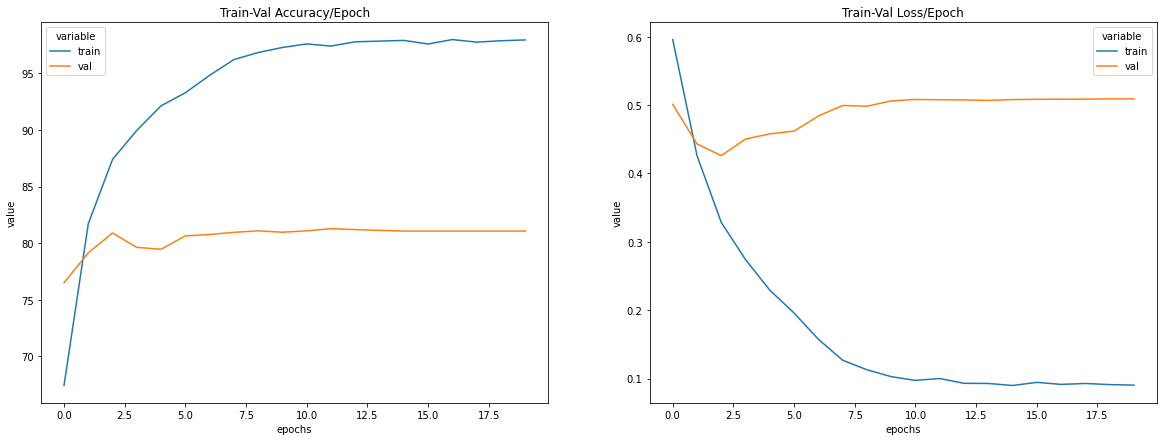

In [40]:
# Create dataframes from the average training accuracy and loss 
train_val_acc_df = pd.DataFrame.from_dict(epoch_accuracies).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(epoch_losses).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [41]:
# Get the test accuracy and labels
y_pred_list = []
y_actual_list = []
y_language_task = []
y_loss = 0

with torch.no_grad():

  # Place the model into evaluation mode
    net.eval()

    # Loop over the test set
    for i, data in enumerate(test_loader, 0):

      # Extract the test set components
      sent1_test, sent2_test, task_test, label_test = data

      # Store the language tasks and actual labels to check model performance
      y_actual_list.extend(label_test.tolist())
      y_language_task.extend(task_test)

      # Reshape the test label to have the same dimensions as the model output
      label_test = label_test.type(torch.FloatTensor).reshape((label_test.shape[0], 1))

      # Send the test data to GPU
      sent1_test, sent2_test, label_test = sent1_test.to(device), sent2_test.to(device), label_test.to(device)

      # Get the test set predictions
      test_pred = net(sent1_test, sent2_test)

      # Get the test loss and add it to y_loss
      test_loss = criterion(test_pred, label_test)

      # Add the test loss from that batch to the running total
      y_loss += test_loss.item()
            
      # Get the predicted test labels
      y_test_pred = torch.round(torch.sigmoid(test_pred)).long()

      # Add the test labels to their respective list
      y_pred_list.extend(y_test_pred)

    # Get the average test loss
    y_avg_loss = y_loss/len(test_loader)

In [42]:
# Print the average test loss
print(f'Average test loss: {y_avg_loss}')

Average test loss: 0.5255328292412815


In [43]:
# Create a dataframe from test performance
y_pred = [x.item() for x in y_pred_list]
test_performance = pd.DataFrame(list(zip(y_language_task, y_actual_list, y_pred)),columns =['language', 'actual_label', 'predicted_label'])

In [44]:
# Check the first few rows
test_performance.head()

,language,actual_label,predicted_label
0,translate English to Hindi,0,0
1,translate English to Hindi,0,0
2,translate English to Hindi,1,1
3,translate English to Hindi,0,0
4,translate English to Hindi,1,1


In [45]:
# Write the test set and predictions to a csv
final = pd.concat([test_performance, paraphrase_test[['sentence_1', 'sentence_2']]], axis=1)

In [46]:
final.head()

,language,actual_label,predicted_label,sentence_1,sentence_2
0,translate English to Hindi,0,0,निशा प्रतिदिन दादी को सीतारामजी के मंदिर में द...,जयपुर-कोटा के बीच 248 किलोमीटर की दूरी होने के...
1,translate English to Hindi,0,0,मनरेगा के मजदूर पीएम मोदी को लौटाएंगे पांच रुपए,मिलान कोर्ट ऑफ अपील्स के आदेश के बाद पहली बा...
2,translate English to Hindi,1,1,पाकिस्तान को दिया करारा जवाब,पाक को दिया मुंहतोड़ जवाब
3,translate English to Hindi,0,0,स्कूल में दो बिल्डिंग हैं।,"जिस समय पुलिस स्कूल पहुंची, उस समय करीब पांच ह..."
4,translate English to Hindi,1,1,रेप के मामले में वह पीड़िता से समझौते का दवाब ...,वह पीड़िता से रेप के मामले में समझौते का दवाब ब...


In [47]:
# Get the overall accuracy rate with sklearn accuracy score
# Accuracy is approximately 80%
accuracy_score(y_actual_list, y_pred)

0.8030495552731893

In [48]:
# Get the overall f1-score
f1_score(y_actual_list, y_pred)

0.7658610271903323

In [49]:
# Get the accuracy scores on Hindi
hi_test = test_performance[test_performance.language == 'translate English to Hindi']
# The model performs very well on Hindi
print(accuracy_score(hi_test.actual_label.tolist(), hi_test.predicted_label.tolist()))
# Get the f1-score
print(f1_score(hi_test.actual_label.tolist(), hi_test.predicted_label.tolist()))

0.8638392857142857
0.8530120481927711


In [50]:
# Get the accuracy scores on Tamil
ta_test = test_performance[test_performance.language == 'translate English to Tamil']
print(accuracy_score(ta_test.actual_label.tolist(), ta_test.predicted_label.tolist()))
# Get the f1-score
print(f1_score(ta_test.actual_label.tolist(), ta_test.predicted_label.tolist()))

0.6690140845070423
0.5154639175257733


In [51]:
# Get the accuracy scores on Malayalam
ml_test = test_performance[test_performance.language == 'translate English to Malayalam']
print(accuracy_score(ml_test.actual_label.tolist(), ml_test.predicted_label.tolist()))
# Get the f1-score
print(f1_score(ml_test.actual_label.tolist(), ml_test.predicted_label.tolist()))

0.7755555555555556
0.7170868347338936


In [52]:
# Get the accuracy scores on Punjabi
pb_test = test_performance[test_performance.language == 'translate English to Punjabi']
print(accuracy_score(pb_test.actual_label.tolist(), pb_test.predicted_label.tolist()))
# Get the f1-score
print(f1_score(pb_test.actual_label.tolist(), pb_test.predicted_label.tolist()))

0.972
0.9731800766283524


In [53]:
# Let's see the number of mistakes the model is making (on what language tasks)
cm = confusion_matrix(y_actual_list, y_pred)
cm

array([[757, 124],
       [186, 507]])

In [54]:
# Check the confusiom matrix on Hindi
confusion_matrix(hi_test.actual_label.tolist(), hi_test.predicted_label.tolist())

array([[210,  41],
       [ 20, 177]])

In [55]:
# Check the confusiom matrix on Tamil
confusion_matrix(ta_test.actual_label.tolist(), ta_test.predicted_label.tolist())

array([[210,  43],
       [ 98,  75]])

In [56]:
# Check the confusiom matrix on Malayalam
confusion_matrix(ml_test.actual_label.tolist(), ml_test.predicted_label.tolist())

array([[221,  37],
       [ 64, 128]])

In [57]:
# Check the confusiom matrix on Punjabi
confusion_matrix(pb_test.actual_label.tolist(), pb_test.predicted_label.tolist())

array([[116,   3],
       [  4, 127]])